# Ancient-to-Film GAN — CycleGAN Training Notebook
**Deliverable 2 | Implementation & Early Evaluation**

This notebook provides a minimal, end-to-end CycleGAN training scaffold for unpaired image-to-image translation.
- **Domain A**: Ancient paintings (`data/A`)
- **Domain B**: Film-style photos (`data/B`)

> Tip: Start with small images (128×128) and a few epochs to verify the pipeline.

In [12]:
!ls -R /content/EEE6778_CTGAN_NHTS/results | head -30

/content/EEE6778_CTGAN_NHTS/results:
checkpoints
samples

/content/EEE6778_CTGAN_NHTS/results/checkpoints:

/content/EEE6778_CTGAN_NHTS/results/samples:


In [14]:
# 搜尋所有 .pt 模型檔（checkpoint）
!find /content -type f -name "*.pt"

# 搜尋所有生成圖片（AtoB）
!find /content -type f -name "*AtoB.png" | head -20

/content/EEE6778_CTGAN_NHTS/EEE6778_CTGAN_NHTS/results/checkpoints/cyclegan_ultra_epoch_01.pt
/content/EEE6778_CTGAN_NHTS/EEE6778_CTGAN_NHTS/results/samples/step000200_AtoB.png


In [15]:
# 把檔案搬到正確的外層 results/ 資料夾
!cp -r /content/EEE6778_CTGAN_NHTS/EEE6778_CTGAN_NHTS/results/checkpoints/* /content/EEE6778_CTGAN_NHTS/results/checkpoints/
!cp -r /content/EEE6778_CTGAN_NHTS/EEE6778_CTGAN_NHTS/results/samples/* /content/EEE6778_CTGAN_NHTS/results/samples/

# 檢查外層是否有檔案
!ls -R /content/EEE6778_CTGAN_NHTS/results | head -30

/content/EEE6778_CTGAN_NHTS/results:
checkpoints
samples

/content/EEE6778_CTGAN_NHTS/results/checkpoints:
cyclegan_ultra_epoch_01.pt

/content/EEE6778_CTGAN_NHTS/results/samples:
step000200_A.png
step000200_AtoB.png


In [18]:
!git config --global user.name "samwu15"
!git config --global user.email "cywu508608@gmail.com"

In [19]:
%cd /content/EEE6778_CTGAN_NHTS
!git add results/
!git commit -m "Add CycleGAN model checkpoint and generated samples"

/content/EEE6778_CTGAN_NHTS
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	EEE6778_CTGAN_NHTS/

nothing added to commit but untracked files present (use "git add" to track)


In [3]:
!git clone https://github.com/samwu15/EEE6778_CTGAN_NHTS.git
%cd EEE6778_CTGAN_NHTS
!ls data

Cloning into 'EEE6778_CTGAN_NHTS'...
remote: Enumerating objects: 2883, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 2883 (delta 5), reused 10 (delta 1), pack-reused 2863 (from 3)
Receiving objects: 100% (2883/2883), 471.51 MiB | 25.56 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (2835/2835), done.
/content/EEE6778_CTGAN_NHTS/EEE6778_CTGAN_NHTS
A  B


In [20]:
from google.colab import files
files.download('/content/EEE6778_CTGAN_NHTS/results/samples/step000200_AtoB.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 0. Environment & Config

In [4]:

import os, random, itertools, time, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Paths
ROOT = Path("..").resolve() if (Path.cwd().name == "notebooks") else Path(".").resolve()
DATA_A = ROOT / "data" / "A"
DATA_B = ROOT / "data" / "B"
OUT_SAMPLES = ROOT / "results" / "samples"
OUT_CKPTS = ROOT / "results" / "checkpoints"
OUT_SAMPLES.mkdir(parents=True, exist_ok=True)
OUT_CKPTS.mkdir(parents=True, exist_ok=True)

# Hyperparameters (start small for demo)
IMG_SIZE = 128
BATCH_SIZE = 2
EPOCHS = 5
LR_G = 2e-4
LR_D = 2e-4
LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0
NUM_WORKERS = 2


## 1. Dataset (Unpaired)

In [5]:

# --- Robust Dataset Setup (safe version) ---
import random
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# 若環境 cell 沒跑，給預設值
IMG_SIZE = 64
SUBSET_A = 100
SUBSET_B = 100
BATCH_SIZE = 1
NUM_WORKERS = 2

# 根目錄推斷（Notebook通常在 notebooks/ 內）
ROOT = Path("..").resolve() if (Path.cwd().name == "notebooks") else Path(".").resolve()
DATA_A = ROOT / "data" / "A"
DATA_B = ROOT / "data" / "B"
print("ROOT =", ROOT)
print("DATA_A exists:", DATA_A.exists(), "| DATA_B exists:", DATA_B.exists())

# 檢查圖檔數量
def count_images(p):
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    files = []
    for e in exts:
        files += list(p.glob(e))
    return len(files)

cntA = count_images(DATA_A)
cntB = count_images(DATA_B)
print(f"Found images -> A: {cntA} | B: {cntB}")
assert cntA > 0 and cntB > 0, "data/A 或 data/B 沒有找到圖檔（.jpg/.png）。"

# 資料轉換
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

class UnpairedImageDataset(Dataset):
    def __init__(self, dir_a, dir_b, transform=None):
        exts = {".jpg",".jpeg",".png",".JPG",".JPEG",".PNG"}
        self.paths_a = sorted([p for p in Path(dir_a).glob("*") if p.suffix in exts])
        self.paths_b = sorted([p for p in Path(dir_b).glob("*") if p.suffix in exts])
        self.transform = transform
        if len(self.paths_a) == 0 or len(self.paths_b) == 0:
            raise RuntimeError("請確認 data/A 與 data/B 內有圖檔（.jpg/.png）。")
    def __len__(self):
        return max(len(self.paths_a), len(self.paths_b))
    def __getitem__(self, idx):
        pa = self.paths_a[idx % len(self.paths_a)]
        pb = self.paths_b[random.randint(0, len(self.paths_b)-1)]
        ia, ib = Image.open(pa).convert("RGB"), Image.open(pb).convert("RGB")
        if self.transform:
            ia = self.transform(ia)
            ib = self.transform(ib)
        return ia, ib

ds = UnpairedImageDataset(DATA_A, DATA_B, transform=tfm)
# drop_last=True 可避免最後一個 batch 不足造成 shape 問題
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
print("✅ DataLoader 建立成功，dataset 長度 =", len(ds))



ROOT = /content/EEE6778_CTGAN_NHTS/EEE6778_CTGAN_NHTS
DATA_A exists: True | DATA_B exists: True
Found images -> A: 2192 | B: 628
✅ DataLoader 建立成功，dataset 長度 = 2192


### Preview a mini-batch

Batch shapes: torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


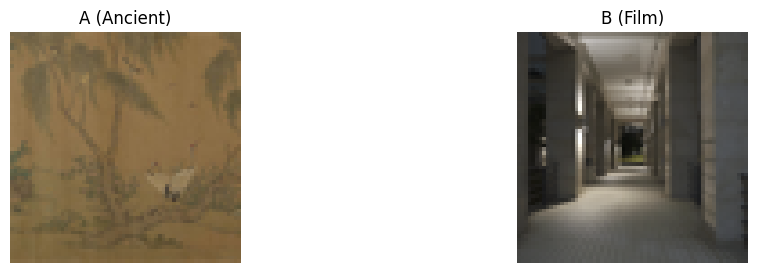

In [6]:

import matplotlib.pyplot as plt
import torch
import numpy

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0,1)

# 確保 dl 存在
if 'dl' not in globals():
    raise RuntimeError("DataLoader (dl) 尚未建立，請先執行 Dataset 的 cell。")

batch = next(iter(dl))
a_batch, b_batch = batch
print("Batch shapes:", a_batch.shape, b_batch.shape)

fig, axes = plt.subplots(1, a_batch.shape[0]*2, figsize=(12, 3))
for i in range(a_batch.shape[0]):
    axes[2*i].imshow(denorm(a_batch[i]).permute(1,2,0).numpy())
    axes[2*i].set_title("A (Ancient)"); axes[2*i].axis("off")
    axes[2*i+1].imshow(denorm(b_batch[i]).permute(1,2,0).numpy())
    axes[2*i+1].set_title("B (Film)"); axes[2*i+1].axis("off")
plt.show()



## 2. Models (Generator & Discriminator)

In [7]:

from src.cyclegan_min import GeneratorResnet, DiscriminatorPatchGAN

# Generators: A->B (G_AB) and B->A (G_BA)
G_AB = GeneratorResnet().to(DEVICE)
G_BA = GeneratorResnet().to(DEVICE)

# Discriminators: for domain B (D_B) and domain A (D_A)
D_B = DiscriminatorPatchGAN().to(DEVICE)
D_A = DiscriminatorPatchGAN().to(DEVICE)

# Init weights
def init_weights(m):
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, torch.nn.InstanceNorm2d):
        if m.affine:
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.zeros_(m.bias)

G_AB.apply(init_weights); G_BA.apply(init_weights); D_A.apply(init_weights); D_B.apply(init_weights)

# Losses & Optimizers
mse = nn.MSELoss()
l1  = nn.L1Loss()
opt_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=LR_G, betas=(0.5, 0.999))
opt_D_A = torch.optim.Adam(D_A.parameters(), lr=LR_D, betas=(0.5, 0.999))
opt_D_B = torch.optim.Adam(D_B.parameters(), lr=LR_D, betas=(0.5, 0.999))

# Buffers for GAN targets
def real_like(x): return torch.ones_like(x, device=DEVICE)
def fake_like(x): return torch.zeros_like(x, device=DEVICE)


## 3. Training Loop (Toy Epochs)

In [8]:
# ====== TURBO SETTINGS ======
FAST_MODE = "lightning"   # "demo" 或 "lightning"
if FAST_MODE == "demo":
    IMG_SIZE = 96
    EPOCHS = 2
    SUBSET_A = 300
    SUBSET_B = 300
    N_RES = 3
    USE_ID_LOSS = True
elif FAST_MODE == "lightning":
    IMG_SIZE = 64
    EPOCHS = 1
    SUBSET_A = 120
    SUBSET_B = 120
    N_RES = 2
    USE_ID_LOSS = False
else:
    raise ValueError

BATCH_SIZE = 1
NUM_WORKERS = 2  # Colab 可用 2


In [9]:

from PIL import Image
from tqdm import tqdm
import torch, math

# ✅ 超快設定
EPOCHS = 1                   # 只跑一個 epoch
MAX_STEPS_PER_EPOCH = 200    # 每個 epoch 最多 200 個 batch
SAVE_EVERY = 200             # 只存一次圖（跑完前後各一次）
LAMBDA_ID = 0.0              # 關閉 identity loss
IMG_SIZE = 64                # 建議搭配 Dataset cell 也改為 64
use_amp = torch.cuda.is_available()

# ⚙️ 新版 AMP
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

def save_sample(a, b_fake, step, out_dir=OUT_SAMPLES):
    def _denorm(x): return (x * 0.5 + 0.5).clamp(0,1)
    a = _denorm(a.detach().cpu())
    b_fake = _denorm(b_fake.detach().cpu())
    a0 = (a[0].permute(1,2,0).numpy()*255).astype("uint8")
    b0 = (b_fake[0].permute(1,2,0).numpy()*255).astype("uint8")
    Image.fromarray(a0).save(out_dir / f"step{step:06d}_A.png")
    Image.fromarray(b0).save(out_dir / f"step{step:06d}_AtoB.png")

step = 0
for epoch in range(1, EPOCHS+1):
    pbar = tqdm(dl, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for i, (a, b) in enumerate(pbar, 1):
        if i > MAX_STEPS_PER_EPOCH:
            break

        a = a.to(DEVICE, non_blocking=True)
        b = b.to(DEVICE, non_blocking=True)

        # --- Train G ---
        opt_G.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=use_amp):
            b_fake = G_AB(a)
            a_rec  = G_BA(b_fake)
            a_fake = G_BA(b)
            b_rec  = G_AB(a_fake)

            pred_b = D_B(b_fake)
            pred_a = D_A(a_fake)
            loss_G = (
                mse(pred_b, real_like(pred_b)) +
                mse(pred_a, real_like(pred_a)) +
                l1(a_rec, a) * LAMBDA_CYCLE +
                l1(b_rec, b) * LAMBDA_CYCLE
            )
        scaler.scale(loss_G).backward()
        scaler.step(opt_G); scaler.update()

        # --- Train D_A ---
        opt_D_A.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=use_amp):
            loss_D_A = 0.5*(mse(D_A(a), real_like(D_A(a))) + mse(D_A(a_fake.detach()), fake_like(D_A(a_fake.detach()))))
        scaler.scale(loss_D_A).backward(); scaler.step(opt_D_A); scaler.update()

        # --- Train D_B ---
        opt_D_B.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=use_amp):
            loss_D_B = 0.5*(mse(D_B(b), real_like(D_B(b))) + mse(D_B(b_fake.detach()), fake_like(D_B(b_fake.detach()))))
        scaler.scale(loss_D_B).backward(); scaler.step(opt_D_B); scaler.update()

        step += 1
        if step % SAVE_EVERY == 0 or i == MAX_STEPS_PER_EPOCH:
            save_sample(a, b_fake, step)

        pbar.set_postfix({
            "G": f"{loss_G.item():.3f}",
            "D_A": f"{loss_D_A.item():.3f}",
            "D_B": f"{loss_D_B.item():.3f}"
        })

    # ✅ 存 checkpoint（給介面使用）
    torch.save({
        "G_AB": G_AB.state_dict(),
        "G_BA": G_BA.state_dict(),
        "D_A": D_A.state_dict(),
        "D_B": D_B.state_dict(),
        "epoch": epoch,
        "fast_mode": "ultra",
        "img_size": IMG_SIZE
    }, OUT_CKPTS / f"cyclegan_ultra_epoch_{epoch:02d}.pt")
    print(f"[Epoch {epoch}] checkpoint saved.")

print("✅ Training finished (ULTRA FAST MODE).")


[Epoch 1] checkpoint saved.
✅ Training finished (ULTRA FAST MODE).


## 4. Inference Helper

In [10]:

@torch.inference_mode()
def translate_image(path_in, path_out, ckpt=None, direction="A2B"):
    img = Image.open(path_in).convert("RGB")
    x = tfm(img).unsqueeze(0).to(DEVICE)
    if ckpt:
        state = torch.load(ckpt, map_location=DEVICE)
        G_AB.load_state_dict(state["G_AB"]); G_BA.load_state_dict(state["G_BA"])
    if direction == "A2B":
        y = G_AB(x)
    else:
        y = G_BA(x)
    y = denorm(y[0].cpu()).permute(1,2,0).numpy()
    Image.fromarray((y*255).astype("uint8")).save(path_out)
    return path_out

# Example:
# translate_image(ROOT/'data/A/sample.jpg', ROOT/'results/samples/sample_A2B.png', ckpt=ROOT/'results/checkpoints/cyclegan_epoch_01.pt')


## 5. Notes for Deliverable 2 Report


- Keep **EPOCHS small** (e.g., 3–5) and **IMG_SIZE=128** for a quick demo.
- Save a few outputs in `results/samples/` and insert them into your report.
- Record losses per epoch; optionally add a simple loss curve.
- Mention compute setup (CPU/GPU), and any training instability or artifacts observed.
- For interface (Step 3), load the latest checkpoint in `ui/app.py` and call `translate_image`.
